In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data as Data
from torchvision import transforms


## 准备训练数据集MNIST
train_data = torchvision.datasets.MNIST(
    root = "./data/MNIST",train=True,transform = transforms.ToTensor(),download=True

)

## 定义一个数据加载器
train_loader = Data.DataLoader(dataset=train_data,batch_size=64,shuffle = True,num_workers=2)

## 准备需要使用的测试数据集
test_data = torchvision.datasets.MNIST(root="./data/MNIST",train = False,transform = transforms.ToTensor(),download=True)

## 定义一个数据加载
test_loader = Data.DataLoader(dataset=test_data,batch_size=64,shuffle = True,num_workers=2)

## 训练集包含60000 28 x 28灰度图像 测试集包含10000 28 x 28




d:\Application\Anaconda\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
## 搭建RNN分类器
# import hiddenlayer as h1
from sklearn.exceptions import NonBLASDotWarning
class RNNimc(nn.Module):
    def __init__(self,input_dim,hidden_dim,layer_dim,output_dim):

        """
        input_dim:输入数据的维度（图片每一行的像素点784）
        hidden_dim:隐藏层神经元个数
        layer_dim:RNN层数
        output_dim:隐藏层输出的神经元个数（分类的数量）

        """
        super(RNNimc,self).__init__()

        self.hidden_dim = hidden_dim ## 隐藏层神经元个数
        self.layer_dim = layer_dim  ## RNN的层数

        ## RNN  实例化一个RNN对象  指定输入输出格式：batch_size seq  feature  激活函数采用Relu
        self.rnn = nn.RNN(input_dim,hidden_dim,layer_dim,batch_first = True,nonlinearity = 'relu')

        ## 连接全连接层
        self.fc1 = nn.Linear(hidden_dim,output_dim)

    def forward(self,x):

        ## 前向传播
        ## x:[batch,time_step,input_dim]  time_step = 图像的所有像素数量 / input_dim
        ## out:[batch,time_step,output_dim]
        ## h_n:[layer_dim,batch,hidden_dim]
        ## 第一个参数是需要处理的数据x 第二个参数是：初始的隐藏层输出
        ## out是最后一层的输出特征  h_n表示隐藏层的输出
        out,h_n = self.rnn(x,None)

        ## 选取组后一个时间点的out进行输出
        out = self.fc1(out[:,-1,:])
        return out

## 调用模型
input_dim = 28 ## 图片每行的像素数量
hidden_dim = 128  ## RNN神经元个数
layer_dim = 1 ## RNN的层数
output_dim = 10 ## 隐藏层输出的维度(10类图像)

MyRNNimc = RNNimc(input_dim,hidden_dim,layer_dim,output_dim)
print(MyRNNimc)

# ## 上面定义的RNN网络中，包括两个层级，一个是包含128个RNN神经元的RNN层，另一个是输入128个神经元 输出10个神经元的全连接层。针对网络结构hiddenlayer库进行可视化
# h1_graph = h1.build_graph(MyRNNimc,torch.zeros([1,28,28]))

RNNimc(
  (rnn): RNN(28, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


In [3]:
## 对模型进行训练
from pickletools import optimize

optimizer = torch.optim.RMSprop(MyRNNimc.parameters(),lr = 0.0003)
criterion  = nn.CrossEntropyLoss()  ## 损失函数
train_loss_all = []
train_acc_all = []
test_loss_all = []
test_acc_all = []
num_epochs = 30

for epoch in range(num_epochs):
    print('Epoch{}/{}'.format(epoch,num_epochs - 1))
    MyRNNimc.train() ## 设置模型为训练模式
    corrects = 0
    train_num = 0

    for step,(b_x,b_y) in enumerate(train_loader):
        ## input: [batch,time_step,input_dim]
        xdata = b_x.view(-1,28,28)
        output = MyRNNimc(xdata)
        pre_lab = torch.argmax(output,1)
        loss = criterion(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss += loss.item() * b_x.size(0)
        corrects += torch.sum(pre_lab==b_y.data)
        train_num += b_x.size(0)

    ## 计算经过一个epoch的训练之后在训练集上的损失和精度
    train_loss_all.append(loss / train_num)
    train_acc_all.append(corrects.double().item() / train_num)
    print('{} Train Loss:{:.4f} Train Acc:{:.4f}'.format(epoch,train_loss_all[-1],train_acc_all[-1]))

    ## 设置模型为验证模式
    MyRNNimc.eval()
    corrects = 0
    test_num = 0

    for step,(b_x,b_y) in enumerate(test_loader):
        ## input:[batch,time_step,input_dim]
        xdata = b_x.view(-1,28,28)
        output = MyRNNimc(xdata)
        pre_lab = torch.argmax(output,1)
        loss = criterion(output,b_y)
        loss+= loss.item() * b_x.size(0)
        corrects += torch.sum(pre_lab == b_y.data)
        test_num += b_x.size(0)

    ## 计算经过一个epoch的训练之后再测试集上的损失和精度
    test_loss_all.append(loss / test_num)
    test_acc_all.append(corrects.double().item() / test_num)

    print('{} Test Loss:{:.4f} Test Acc:{:.4f}'.format(epoch,test_loss_all[-1],test_acc_all[-1]))

Epoch0/29
0 Train Loss:0.0004 Train Acc:0.6748
0 Test Loss:0.0004 Test Acc:0.8007
Epoch1/29
1 Train Loss:0.0003 Train Acc:0.8306
1 Test Loss:0.0009 Test Acc:0.7979
Epoch2/29
2 Train Loss:0.0001 Train Acc:0.8810
2 Test Loss:0.0002 Test Acc:0.9044
Epoch3/29
3 Train Loss:0.0001 Train Acc:0.9044
3 Test Loss:0.0004 Test Acc:0.9116
Epoch4/29
4 Train Loss:0.0000 Train Acc:0.9209
4 Test Loss:0.0009 Test Acc:0.9351
Epoch5/29
5 Train Loss:0.0001 Train Acc:0.9333
5 Test Loss:0.0002 Test Acc:0.9394
Epoch6/29
6 Train Loss:0.0000 Train Acc:0.9422
6 Test Loss:0.0002 Test Acc:0.9507
Epoch7/29
7 Train Loss:0.0000 Train Acc:0.9480
7 Test Loss:0.0005 Test Acc:0.9342
Epoch8/29
8 Train Loss:0.0000 Train Acc:0.9542
8 Test Loss:0.0003 Test Acc:0.9521
Epoch9/29
9 Train Loss:0.0000 Train Acc:0.9585
9 Test Loss:0.0002 Test Acc:0.9634
Epoch10/29
10 Train Loss:0.0001 Train Acc:0.9621
10 Test Loss:0.0004 Test Acc:0.9626
Epoch11/29
11 Train Loss:0.0000 Train Acc:0.9650
11 Test Loss:0.0000 Test Acc:0.9658
Epoch12/29

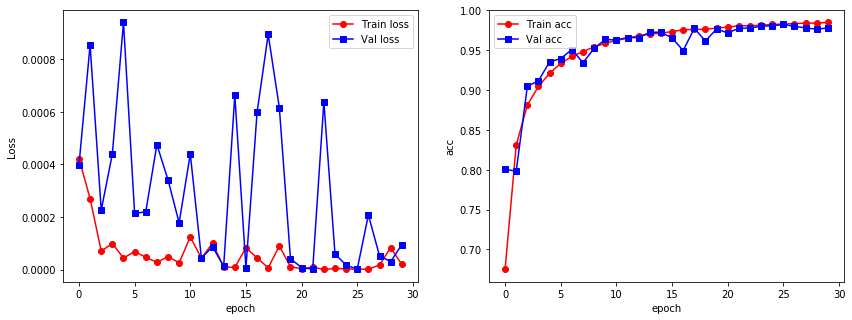

In [4]:
## 将网络在训练集和测试集上的损失以及预测精度使用折线图进行可视化
from re import A


plt.figure(figsize = (14,5))
plt.subplot(1,2,1)
plt.plot(train_loss_all,"ro-",label = "Train loss")
plt.plot(test_loss_all,"bs-",label = "Val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(train_acc_all,"ro-",label = "Train acc")
plt.plot(test_acc_all,"bs-",label = "Val acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

